In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import pygmt

In [238]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Setup the grid

In [11]:
region = [17.4, 20.1, -75.1, -71.5]

In [4]:
def setup_grid(num_tracks, region, inc):
    # 1. Setup parameters
    n_tracks = num_tracks
    
    # 2. Create coordinate vectors
    grid_lon = np.arange(region[2], region[3], inc)
    grid_lat = np.arange(region[0], region[1], inc)
    
    # 3. Get dimensions
    nrows = grid_lat.shape[0]
    ncols = grid_lon.shape[0]
    
    # 4. Create the meshgrid
    grid_lon_mesh, grid_lat_mesh = np.meshgrid(grid_lon, grid_lat)
    
    return grid_lon_mesh, grid_lat_mesh, nrows, ncols

In [5]:
grid_lon_mesh, grid_lat_mesh, nrows, ncols = setup_grid(2, region, 0.05)

print(f"Grid dimensions: {nrows} rows x {ncols} columns")
print(f"Mesh shape: {grid_lon_mesh.shape}")

Grid dimensions: 55 rows x 72 columns
Mesh shape: (55, 72)


# Load GPS velocity file
GNSS file format: Lon Lat VE VN VU SE SN SU ID

Region format: [South, North, West, East]

In [6]:
def read_GNSS_file(filename, region):
    gnss = pd.read_csv(filename, sep=r'\s+', skiprows=1, names=['Lon', 'Lat', 'VE', 'VN', 'VU', 'SE', 'SN', 'SU', 'ID'],
                       dtype = {'Lon': float, 'Lat': float, 'VE': float, 'VN': float, 'VU': float, 'SE': float, 'SN': float, 'SU': float, 'ID': str})
    mask = (gnss['Lat'] > region[0]) & (gnss['Lat'] < region[1]) & (gnss['Lon'] > region[2]) & (gnss['Lon'] < region[3])
    gnss = gnss[mask]
    return gnss


In [12]:
gnss = read_GNSS_file('../UNR_B12_C10_C22.txt', region)

print(f"The amount of available GNSS stations is: {len(gnss)}")
gnss.head()

The amount of available GNSS stations is: 89


,Lon,Lat,VE,VN,VU,SE,SN,SU,ID
4,-72.27,18.63,-6.772,-5.246,-0.380,2.21,2.01,100.0,BRPS*
6,-71.67,19.42,-8.092,-5.603,-0.377,0.55,0.52,100.0,CAP2*
10,-71.57,18.32,-2.652,-2.080,-1.242,0.74,0.72,100.0,ESCO*
12,-72.01,19.14,-6.085,-9.431,1.436,1.32,1.21,100.0,HINC*
13,-72.63,18.51,-4.706,-5.928,0.131,1.03,1.01,100.0,LEOG*


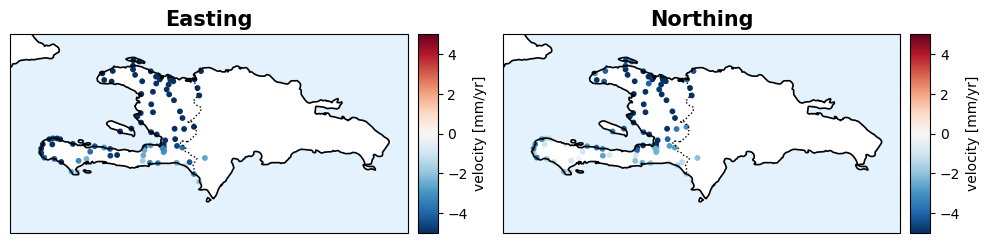

In [239]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 2, figsize=(10, 6), subplot_kw={'projection': proj})

titles = ['Easting', 'Northing']
data_list = [gnss.VE, gnss.VN]

for i, ax in enumerate(axes):
    ax.set_extent([-75.0, -68.0, 17.0, 20.5], crs=proj)
    
    # Add aesthetic map features
    ax.add_feature(cfeature.OCEAN, facecolor='#e3f2fd', zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2, edgecolor='black', zorder=4)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', zorder=4)
    
    sc = ax.scatter(gnss.Lon, gnss.Lat, c=data_list[i], 
                    cmap='RdBu_r', s=10, vmin=-5, vmax=5)
    
    ax.set_title(titles[i], fontsize=15, fontweight='bold')
    # plt.colorbar(sc, ax=ax, label='velocity [mm/yr]', shrink=0.7)
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    
    plt.colorbar(sc, cax=cax, label='velocity [mm/yr]')

plt.tight_layout()
plt.show()

# Load InSAR tracks

The InSAR data has been pre\-processing, including remove the isolated island and downsample already.

The input file should contain these information: 'G_insar', 'az', 'inc', 'lat', 'lon', 'losx', 'losy', 'losz', 'velo', 'velostd'

In [14]:
from scipy.io import loadmat

In [16]:
def load_insar_data(filename):
    file = loadmat(filename, squeeze_me=True)
    insar_dict = {key: file[key] for key in file.keys() if key in file}
    
    return insar_dict

In [17]:
# Usage
d142a1 = load_insar_data('../DT142A1all.mat')
a04a1 = load_insar_data('../AT04A1all.mat')

print(a04a1.keys())
print(a04a1['velo'].shape, d142a1['velo'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'G_insar', 'az', 'inc', 'lat', 'lon', 'losx', 'losy', 'losz', 'maskDR', 'maskHaiti', 'maskhisp', 'velo', 'velostd'])
(20, 42) (25, 20)


# Create G_insar

In [18]:
# Stack all the tracks together. Please follow the order of the tracks
alllat = np.concatenate([d142a1['lat'].flatten(), a04a1['lat'].flatten()])
alllon = np.concatenate([d142a1['lon'].flatten(), a04a1['lon'].flatten()])
vinsar = np.concatenate([d142a1['velo'].flatten(), a04a1['velo'].flatten()])

# Flatten the grid meshes
grid_lon_flat = grid_lon_mesh.flatten()
grid_lat_flat = grid_lat_mesh.flatten()

print(f"Length of the alllat: {alllat.shape}")
print(f"Length of the vindar: {vinsar.shape}")
print(f"Length of the grid_lon: {grid_lon_flat.shape}")

Length of the alllat: (1340,)
Length of the vindar: (1340,)
Length of the grid_lon: (3960,)


In [19]:
# Calculate total number of InSAR observations
Ninsar = d142a1['velo'].size + a04a1['velo'].size
print(f"Total InSAR observations (Ninsar): {Ninsar}")

Total InSAR observations (Ninsar): 1340


In [20]:
# Concatenate Line-of-Sight (LOS) components
# We flatten each to ensure they are 1D before joining
losx = np.concatenate([d142a1['losx'].flatten(), a04a1['losx'].flatten()])
losy = np.concatenate([d142a1['losy'].flatten(), a04a1['losy'].flatten()])
losz = np.concatenate([d142a1['losz'].flatten(), a04a1['losz'].flatten()])

print(f"LOS vector length: {len(losx)}")

LOS vector length: 1340


In [21]:
from scipy.spatial import cKDTree
from scipy.sparse import lil_matrix, hstack

In [22]:
def build_Ginsar_matrix(all_lon, all_lat, vinsar, los_xyz, grid_lon_flat, grid_lat_flat):
    # 1. Setup
    Ninsar = len(vinsar)
    num_grid_cells = len(grid_lon_flat)
    losx, losy, losz = los_xyz
    
    # Use LIL matrix for efficient construction of sparse matrices
    Gx = lil_matrix((Ninsar, num_grid_cells))
    Gy = lil_matrix((Ninsar, num_grid_cells))
    Gz = lil_matrix((Ninsar, num_grid_cells))

    # 2. Fast Nearest Neighbor Search
    # Create a tree of the grid coordinates
    grid_coords = np.vstack((grid_lon_flat, grid_lat_flat)).T
    tree = cKDTree(grid_coords)
    
    # Query the tree for all InSAR points at once
    insar_coords = np.vstack((all_lon, all_lat)).T
    distances, indices = tree.query(insar_coords)

    # 3. Fill the Matrices (Vectorized Logic)
    for i in range(Ninsar):
        # Distance threshold (1 degree) and NaN check
        if distances[i] < 1.0 and not np.isnan(vinsar[i]):
            idx = indices[i]
            Gx[i, idx] = losx[i]
            Gy[i, idx] = losy[i]
            Gz[i, idx] = losz[i]

    # 4. Concatenate into final Sparse Design Matrix [Gx, Gy, Gz]
    G_insar = hstack([Gx, Gy, Gz]).tocsr()

    return G_insar, Gx

In [23]:
def plot_grid_occupancy(grid_lon_flat, grid_lat_flat, Gx):
    # Calculate which cells have data (sum across rows of Gx)
    sumsX = np.array(Gx.sum(axis=0)).flatten()
    
    # Define colors: Light Gray for empty, Blue for occupied
    colors = np.full((len(sumsX), 3), [0.0, 0.447, 0.741]) # Default Blue
    colors[sumsX == 0] = [0.83, 0.82, 0.78] # Light Gray
    
    plt.figure(figsize=(10, 7))
    plt.scatter(grid_lon_flat, grid_lat_flat, s=10, c=colors, edgecolors='none')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title("Grid Occupancy (Gray = No InSAR/GNSS Data)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

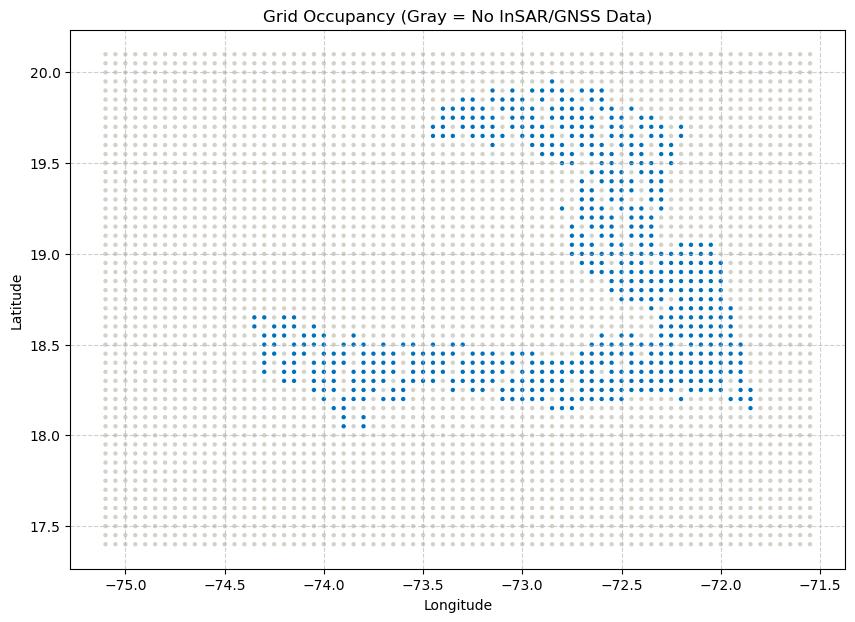

In [24]:
# Usage
los_xyz = (losx, losy, losz)
G_insar, Gx_insar = build_Ginsar_matrix(alllon, alllat, vinsar, los_xyz, grid_lon_flat, grid_lat_flat)
plot_grid_occupancy(grid_lon_flat, grid_lat_flat, Gx_insar)

# Create G_plane

In [25]:
from scipy.sparse import block_diag as sparse_block_diag
from scipy.sparse import csr_matrix

In [26]:
def build_Gplane_matrix(list_of_tracks):
    """
    Creates a sparse block-diagonal design matrix for any number of InSAR tracks.
    
    Parameters:
    list_of_tracks: A list of dictionaries, where each dict has 'lon' and 'lat'.
    
    Returns:
    G_plane: A scipy sparse matrix (CSR format).
    """
    plane_blocks = []
    
    for track in list_of_tracks:
        # 1. Extract and flatten coordinates
        lon = track['lon'].flatten()
        lat = track['lat'].flatten()
        ones = np.ones(len(lon))
        
        # 2. Build the [lon, lat, 1] block for THIS track
        # This is a dense (N x 3) matrix
        block = np.column_stack((lon, lat, ones))
        
        # 3. Convert to sparse and add to our list of blocks
        plane_blocks.append(csr_matrix(block))
    
    # 4. Combine all blocks into one giant block-diagonal matrix
    G_plane = sparse_block_diag(plane_blocks, format='csr')
    
    return G_plane

In [27]:
# Usage
all_my_tracks = [d142a1, a04a1] 
G_plane = build_Gplane_matrix(all_my_tracks)

print(f"Final matrix shape: {G_plane.shape}") # Should be (Total_Points, 3 * Num_Tracks)

Final matrix shape: (1340, 6)


# Creat G_GPS

In [28]:
def build_Ggps_matrix(gnss, grid_lon_flat, grid_lat_flat, threshold=1.0):
    """
    Maps GNSS stations to the nearest grid cells and creates a block-diagonal 
    design matrix for East, North, and Up components.
    """
    Ngps = len(gnss)
    num_cells = len(grid_lon_flat)
    
    # 1. Initialize sparse matrices (LIL format for fast filling)
    Gx = lil_matrix((Ngps, num_cells))
    Gy = lil_matrix((Ngps, num_cells))
    Gz = lil_matrix((Ngps, num_cells))

    # 2. Fast spatial search for nearest grid index
    grid_coords = np.vstack((grid_lon_flat, grid_lat_flat)).T
    tree = cKDTree(grid_coords)
    
    gnss_coords = np.vstack((gnss['Lon'].values, gnss['Lat'].values)).T
    distances, indices = tree.query(gnss_coords)

    # 3. Fill the matrices
    for i in range(Ngps):
        if distances[i] < threshold:
            idx = indices[i]
            Gx[i, idx] = 1.0
            Gy[i, idx] = 1.0
            Gz[i, idx] = 1.0

    # 4. Create block diagonal matrix [Gx 0 0; 0 Gy 0; 0 0 Gz]
    G_gps = sparse_block_diag((Gx, Gy, Gz), format='csr')

    return G_gps, Gx

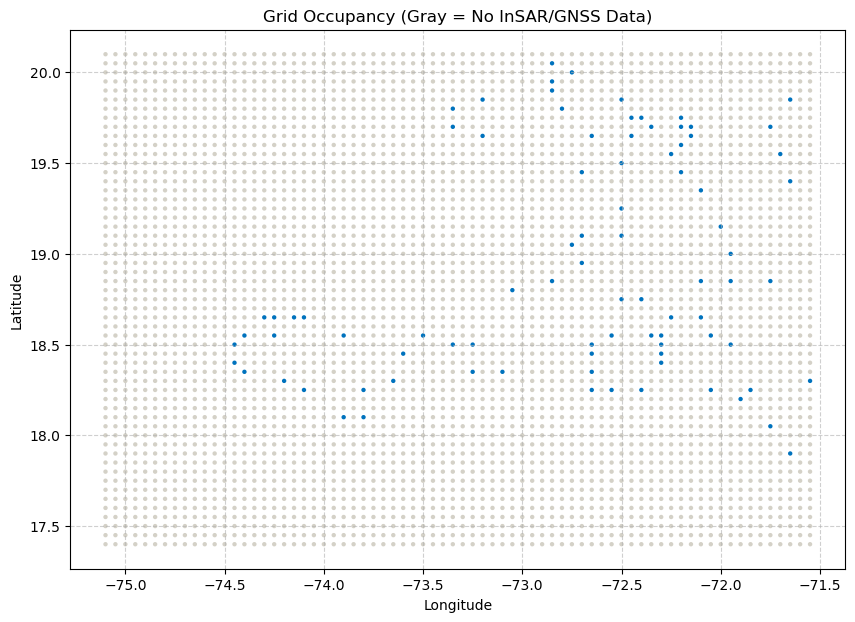

In [29]:
# Usage
G_gps, Gx_GPS = build_Ggps_matrix(gnss, grid_lon_flat, grid_lat_flat)
plot_grid_occupancy(grid_lon_flat, grid_lat_flat, Gx_GPS)

In [114]:
print(f"Final matrix shape: {G_gps.shape}") 

Final matrix shape: (267, 11880)


# Create Laplacian matrix

In [30]:
from scipy.sparse import spdiags

def make_lap(ngrid, nrow, dx, dy):
    """
    Creates a 2D Laplacian smoothing matrix for velocity regularization.
    """
    if dx != dy:
        print('Error: dx must equal dy for now')
        return None
    
    # 1. Initialize diagonals
    # D is the main diagonal
    D = -4 * np.ones(ngrid)
    
    # 2. Boundary Conditions (Matching your MATLAB logic)
    # Top edge
    D[0:nrow] = -3
    # Top-left corner
    D[0] = -2
    
    # Bottom edge
    D[-nrow:] = -3
    # Bottom-right corner
    D[-1] = -2
    
    # 3. Create off-diagonals (1s)
    off_diag = np.ones(ngrid)
    
    # 4. Construct the Sparse Matrix
    # Diagonals: [lower-far, lower-near, main, upper-near, upper-far]
    # Offsets:  [-nrow,     -1,          0,    1,          nrow]
    diags = [off_diag, off_diag, D, off_diag, off_diag]
    offsets = [-nrow, -1, 0, 1, nrow]
    
    Lap = spdiags(diags, offsets, ngrid, ngrid, format='csr')
    
    # 5. Scaling
    Lap = Lap / (2 * dx)
    
    return Lap

In [31]:
# Usage: Create Laplacian smoothing matrix 

# 1. Define grid parameters
grid_size_lon = 0.05
grid_size_lat = 0.05

# 2. Generate the single Laplacian matrix
Lap = make_lap(nrows * ncols, ncols, grid_size_lon, grid_size_lat)

# 3. Create the full block diagonal Laplacian for 3D velocities (East, North, Up)
# This results in a matrix that applies smoothing to Vx, Vy, and Vz independently
full_Lap = sparse_block_diag((Lap, Lap, Lap), format='csr')

print(f"Laplacian shape: {Lap.shape}")
print(f"Full Laplacian shape: {full_Lap.shape}")

Laplacian shape: (3960, 3960)
Full Laplacian shape: (11880, 11880)


# Load GNSS Uncertainty

In [137]:
from scipy.sparse import diags

sig_gps = np.concatenate([gnss['SE'], gnss['SN'], gnss['SU']])
COV_gps = diags(sig_gps**2, offsets=0, format='csr')

print(f"Covariance Matrix shape: {COV_gps.shape}")

Covariance Matrix shape: (267, 267)


# Load InSAR covariance matrix

InSAR covariance matrix should be created already, which included C_h2. Please refer the *create_cov_insar.ipynb* to create the file.

In [33]:
from scipy.sparse import diags, block_diag, csr_matrix, vstack, eye

In [34]:
def build_COV_insar_matrix(track_configs):
    """
    Loads InSAR covariance matrices and applies a diagonal scaling factor.
    
    Parameters:
    track_configs: A list of dictionaries. Each dict contains:
                   'filename': str
                   'scale': float (the multiplier for the diagonal)
                   
    Returns:
    COV_insar_all: A sparse block-diagonal covariance matrix.
    """
    cov_blocks = []
    
    for config in track_configs:
        # 1. Load the .mat file
        data = loadmat(config['filename'])
        C_h2 = data['C_h2']
        
        # 2. Formula: C_h2 + diag(scale * diag(C_h2))
        d = C_h2.diagonal()
        scaling_matrix = diags(config['scale'] * d)
        
        # Combine the original covariance with the added diagonal scaling
        # We convert to CSR format for efficient sparse math
        C_modified = csr_matrix(C_h2 + scaling_matrix)
        
        cov_blocks.append(C_modified)
    
    # 3. Create the global block diagonal matrix
    COV_insar_all = block_diag(cov_blocks, format='csr')
    
    return COV_insar_all

In [35]:
tracks_to_load = [
    {'filename': '../Cov_InSAR_DT142A1.mat', 'scale': 300},
    {'filename': '../Cov_InSAR_AT04A1.mat',  'scale': 1},
]

COV_insar_all = build_COV_insar_matrix(tracks_to_load)
print(f"Total Covariance Shape: {COV_insar_all.shape}")

Total Covariance Shape: (1340, 1340)


# Decide the value of alpha 

We use L-curve to decide the value of alpha.

In [71]:
# Setup Alpha (Smoothing Regularization Weight)
alpha2 = 10e2

print(f"Aeta2: {alpha2:.2e}")

Aeta2: 1.00e+03


# Minimum norm constraint (Optional)

In here, we want to apply the minimum norm to the vertical component only. You can adjust it depends what you need.

In [150]:
# 1. Calculate the total sum of the Laplacian regularization weight matrix
aaL = alpha2 * full_Lap.shape[0]

# 2. GNSS Vertical variance calculations
vu2 = gnss['VU']**2
su2 = gnss['SU']**2
su2_sum = np.sum(su2)

# 3. Calculate Beta2
denominator = su2_sum * full_Lap.shape[0]
beta2 = 1e13 * aaL / denominator

# 4. Create the I2 regularization matrix
I2 = su2_sum * eye(full_Lap.shape[0], format='csr')

print(f"Calculated Beta2: {beta2:.2e}")
print(I2.shape, np.nanmean(I2.toarray()))

Calculated Beta2: 1.19e+10
(11880, 11880) 70.70785210968666


# Stack the matrix together

In [158]:
# 1. Build the Global Covariance Matrix (SIG1)
# Stitches GNSS and InSAR covariance blocks along the diagonal
SIG1 = block_diag((COV_gps, COV_insar_all), format='csr')

# 2. Concatenate the Data Vector (d1)
# Stacking all velocities into one long 1D array
d1 = np.concatenate([
    gnss['VE'], gnss['VN'], gnss['VU'],
    d142a1['velo'].flatten(), a04a1['velo'].flatten()])


# 3. Build the Global Design Matrix (G1)
# Row 1: GNSS part (G_gps matched with zeros for the InSAR plane parameters)
# Row 2: InSAR part (G_insar matched with the G_plane ramp parameters)

# Create the zero padding for the top right
zero_padding = csr_matrix((G_gps.shape[0], G_plane.shape[1]))

# horizontal stack (hstack) for rows, then vertical stack (vstack) to join them
top_row = hstack([G_gps, zero_padding])
bottom_row = hstack([G_insar, G_plane])

G1 = vstack([top_row, bottom_row], format='csr')

print(f"Data vector length: {len(d1)}")
print(f"Design matrix shape: {G1.shape}")

Data vector length: 1607
Design matrix shape: (1607, 11886)


This part of the code performs Data Cleaning (removing NaNs) and then builds the Final Augmented System for the inversion. 

This system combines your observations (GNSS/InSAR) with regularization (Laplacian smoothing and Identity dampening).


In [ ]:
# 1. Create the Mask for NaNs
mask = np.isnan(d1) | np.array(np.isnan(G1.sum(axis=1))).flatten()

# 2. Apply the Mask (Filtering)
d1_clean = d1[~mask]
G1_clean = G1[~mask, :]

# Filter the Covariance Matrix 
SIG1_clean = SIG1[~mask, :][:, ~mask]

# 3. Build the Final Augmented Covariance (SIG)
SIG = block_diag((
    SIG1_clean, 
    alpha2 * eye(full_Lap.shape[0]), 
    beta2 * I2
), format='csr')

# 4. Build the Final Augmented Data Vector (d)
zeros_lap = np.zeros(full_Lap.shape[0])
zeros_i2 = np.zeros(I2.shape[0])
d = np.concatenate([d1_clean, zeros_lap, zeros_i2])

# 5. Build the Final Augmented Design Matrix (G)
num_plane_params = G_plane.shape[1]

# Create zero padding for the right side of the regularization blocks
zero_reg_pad = csr_matrix((full_Lap.shape[0], num_plane_params))

# Construct the blocks
lap_block = hstack([full_Lap, zero_reg_pad])
i2_block = hstack([I2, zero_reg_pad])

# Vertical stack everything together
G = vstack([G1_clean, lap_block, i2_block], format='csr')

print(f"Final System: G matrix is {G.shape[0]} x {G.shape[1]}")

Final System: G matrix is 24634 x 11886


In [162]:
print(f"Data vector length: {len(d)}")
print(f"Design matrix shape: {G.shape}")

Data vector length: 24634
Design matrix shape: (24634, 11886)


# Solve the estimated velocity

In [73]:
from scipy import linalg
from scipy.optimize import lsq_linear
from scipy.sparse.linalg import lsqr

In [ ]:
Lsig = linalg.cholesky(SIG.toarray(), lower=False)
s = Lsig.diagonal()
weights = 1.0 / s

dd = d * weights
W = diags(weights)
GG = W @ G 

In [167]:
print(dd.shape, GG.shape)

(24634,) (24634, 11886)


In [171]:
vhat, istop, itn, normr, *rest = lsqr(GG, dd)

In [178]:
print(f"Data vector length: {len(vhat)}")
print(f"Mean value of the estimated velocity: {np.round(np.nanmean(vhat), 4)}")

Data vector length: 11886
Mean value of the estimated velocity: -2.1666


# Remove the plane parameters for InSAR (Optional)

In [ ]:
import numpy as np

def calculate_track_residuals(vhat, tracks_list, num_grid_params):
    """
    Extracts orbital plane parameters, removes the ramp from each track, 
    and calculates standard Geodetic metrics (RMS and STD).
    """
    # 1. Extract only the plane parameters from the end of vhat
    plane_params_all = vhat[num_grid_params:]
    
    results = []
    
    for i, track in enumerate(tracks_list):
        track_label = track.get('name', f"Track {i+1}")

        # Extract the 3 parameters for each track (a, b, c)
        start_idx = i * 3
        end_idx = start_idx + 3
        pp_current = plane_params_all[start_idx:end_idx]
        
        # Build Design Matrix: [Lon, Lat, 1]
        # Ensure we are using flattened arrays for the matrix math
        lon_f = track['lon'].flatten()
        lat_f = track['lat'].flatten()
        A = np.column_stack((lon_f, lat_f, np.ones_like(lon_f)))

        # Calculate the orbital ramp (linear plane)
        orbital_ramp = A @ pp_current
        
        # Calculate Residual: Observed - Predicted Ramp
        # (Observed velocity contains both signal and the orbital error)
        residual = track['velo'].flatten() - orbital_ramp
        
        # Filter out NaNs for statistical calculations
        valid_mask = ~np.isnan(residual)
        valid_resid = residual[valid_mask]
        num_pixels = len(valid_resid)
        
        if num_pixels > 0:
            rms = np.sqrt(np.mean(valid_resid**2))
            std_dev = np.std(valid_resid)
            
            print(f"Track {i+1} ({track_label}):")
            print(f"   Pixels: {num_pixels}")
            print(f"   RMS:    {rms:.4f} mm/yr")
            print(f"   STD:    {std_dev:.4f} mm/yr")
            
            track['residual_map'] = residual.reshape(track['lon'].shape)
            track['ramp_map'] = orbital_ramp.reshape(track['lon'].shape)
            
            results.append({
                'track_index': i,
                'rms': rms,
                'std': std_dev,
                'n_pixels': num_pixels
            })
        else:
            print(f"Track {i+1}: No valid pixels found.")
            
    return results

In [193]:
# Usage 
d142a1['name'] = "d142a1"
a04a1['name'] = "a04a1"

my_tracks = [d142a1, a04a1]
n_total_grid_cells = 3 * nrows * ncols
rmse_list = calculate_track_residuals(vhat, my_tracks, n_total_grid_cells)

Track 1 (d142a1):
   Pixels: 215
   RMS:    4.1195 mm/yr
   STD:    1.0024 mm/yr
Track 2 (a04a1):
   Pixels: 392
   RMS:    3.6203 mm/yr
   STD:    1.8267 mm/yr


# Get the final estimated velocity

In [194]:
dpred = G @ vhat
resid_data = d.flatten() - dpred.flatten()

rw = linalg.solve_triangular(Lsig, resid_data, lower=False)
# chi2 = np.sum(rw**2) / len(dpred)
chi2 = (rw.T @ rw)/ len(dpred)

print(f"Reduced Chi-Squared: {chi2:.4f}")

Reduced Chi-Squared: 0.0026


In [195]:
# 1. Calculate model uncertainty (standard deviation of the parameters)
# uncertainty_vhat = np.sqrt(cov_vhat.diagonal())

# 2. Calculate data uncertainty (standard deviation of the observations)
data_uncertainty = np.sqrt(SIG.diagonal())

In [196]:
from scipy.interpolate import RegularGridInterpolator

In [ ]:
# 1. Decomposition of vhat
num_plane_params = 3 * len(all_my_tracks)
Nc = int((len(vhat) - num_plane_params) / 3)
Ngps = len(gnss)

Ve_pred = vhat[0:Nc]
Vn_pred = vhat[Nc:2*Nc]
Vu_pred = vhat[2*Nc:3*Nc]

# # Uncertainties (extracted from the diagonal of the covariance if needed)
# Se_pred = uncertainty_vhat[0:Nc]
# Sn_pred = uncertainty_vhat[Nc:2*Nc]
# Su_pred = uncertainty_vhat[2*Nc:3*Nc]

# 2. Setup Interpolation Function
# grid_lat/lon should be your unique 1D axis vectors
lat_axis = np.sort(np.unique(grid_lat_flat))
lon_axis = np.sort(np.unique(grid_lon_flat))

def get_interpolated_grid(pred_vector, target_lat, target_lon):
    # Reshape to 2D grid
    grid_data = pred_vector.reshape((len(lat_axis), len(lon_axis)))
    interp = RegularGridInterpolator((lat_axis, lon_axis), grid_data, 
                                     bounds_error=False, fill_value=None)
    pts = np.column_stack((target_lat, target_lon))
    return interp(pts)

# Perform the "test" interpolation at GNSS locations
Vxtest = get_interpolated_grid(Ve_pred, gnss['Lat'], gnss['Lon'])
Vytest = get_interpolated_grid(Vn_pred, gnss['Lat'], gnss['Lon'])
Vutest = get_interpolated_grid(Vu_pred, gnss['Lat'], gnss['Lon'])

In [198]:
# Model Predictions at Data Points (G * vhat)
Vpred = G @ vhat
Ve_pred_real = Vpred[0:Ngps]
Vn_pred_real = Vpred[Ngps:2*Ngps]
Vu_pred_real = Vpred[2*Ngps:3*Ngps] 

In [243]:
def plot_gnss_corr(obs, pred_real, test_interp, component_name):
    plt.figure(figsize=(5, 4))
    plt.scatter(obs, pred_real, c='b', s=15, label=f'Estimated_V{component_name.lower()}')
    plt.scatter(obs, test_interp, c='r', s=15, label=f'GNSS_V{component_name.lower()}')
    
    corr = np.corrcoef(obs, pred_real)[0, 1]
    plt.title(f"alpha2: {alpha2}, corrcoef: {corr:.4f}")
    plt.xlabel(f"Observed V{component_name} (GNSS)")
    plt.ylabel(f"Predicted V{component_name}")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

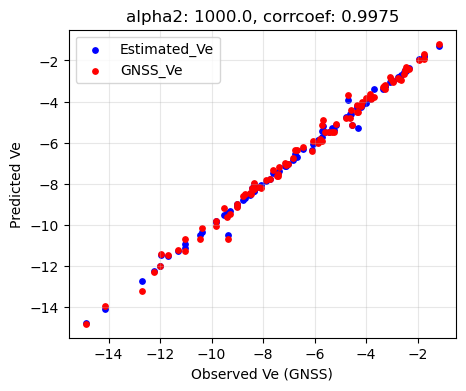

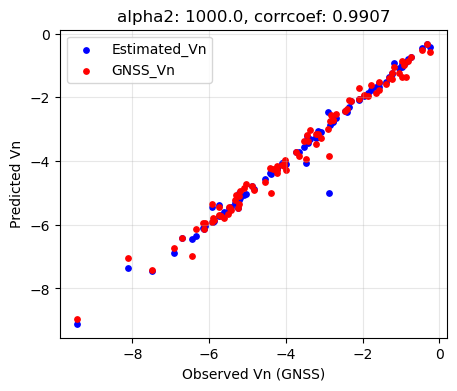

In [244]:
plot_gnss_corr(gnss['VE'], Ve_pred_real, Vxtest, "e")
plot_gnss_corr(gnss['VN'], Vn_pred_real, Vytest, "n")

In [215]:
import cartopy.io.shapereader as shapereader
from shapely.geometry import Point, MultiPolygon
from shapely.ops import unary_union

shpfilename = shapereader.natural_earth(resolution='10m', category='cultural', name='admin_0_countries')
reader = shapereader.Reader(shpfilename)
countries = reader.records()

hispaniola_geom = unary_union([
    country.geometry for country in countries 
    if country.attributes['NAME'] in ['Haiti', 'Dominican Rep.']
])

In [216]:
def get_land_mask(lons, lats, geometry):
    pts = [Point(x, y) for x, y in zip(lons.flatten(), lats.flatten())]
    mask = np.array([geometry.contains(p) for p in pts])
    return mask.reshape(lons.shape)

In [217]:
mask_land = get_land_mask(lons, lats, hispaniola_geom)
mask_final = mask_land

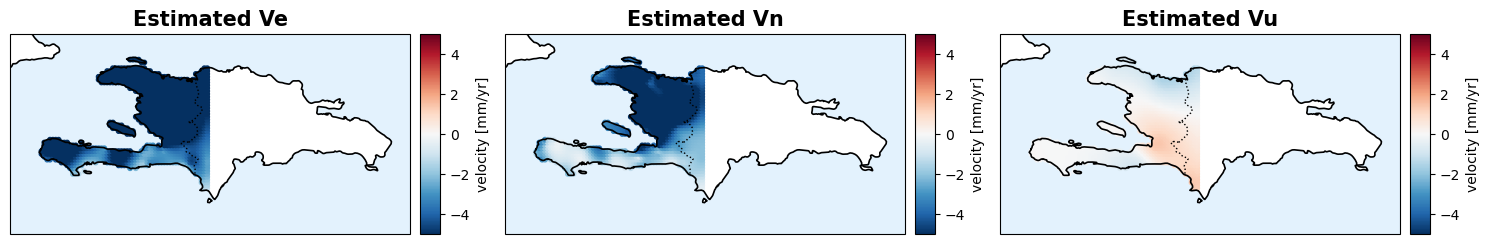

In [240]:
proj = ccrs.PlateCarree()
fig, axes = plt.subplots(1, 3, figsize=(15, 6), subplot_kw={'projection': proj})

data_list = [Ve_pred, Vn_pred, Vu_pred]
titles = ['Estimated Ve', 'Estimated Vn', 'Estimated Vu']

for i, ax in enumerate(axes):
    ax.set_extent([-75.0, -68.0, 17.0, 20.5], crs=proj)
    
    # Add aesthetic map features
    ax.add_feature(cfeature.OCEAN, facecolor='#e3f2fd', zorder=0)
    ax.add_feature(cfeature.COASTLINE, linewidth=1.2, edgecolor='black', zorder=4)
    ax.add_feature(cfeature.BORDERS, linestyle=':', edgecolor='black', zorder=4)

    valid = mask_final.flatten()
    
    sc = ax.scatter(lons.flatten()[valid], lats.flatten()[valid], 
                    c=data_list[i][valid], 
                    cmap='RdBu_r', s=10, vmin=-5, vmax=5, 
                    transform=proj, zorder=3)
    
    ax.set_title(titles[i], fontsize=15, fontweight='bold')
    # plt.colorbar(sc, ax=ax, label='velocity [mm/yr]', fraction=0.046, pad=0.04)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1, axes_class=plt.Axes)
    plt.colorbar(sc, cax=cax, label='velocity [mm/yr]')

plt.tight_layout()
plt.show()